## Same intial loading and cleaning steps ##

In [1]:
# Image Preparation Imports
import cv2
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

file_name = '../data/wiki.mat'

def matlab_datenum_to_date(matlab_dn):
    return datetime.date.fromordinal(int(matlab_dn) - 366)

def compute_wiki_age(photo_year, birth_datenum):
    photo_date = datetime.date(photo_year, 7, 1)
    birth_date = matlab_datenum_to_date(birth_datenum)
    delta = photo_date - birth_date
    return delta.days / 365.2425


def process_matfile(file_name):
    # Load the data
    data = loadmat(file_name)['wiki'][0, 0]
    data_dict = {key: data[key] for key in data.dtype.names}

    # Convert data into filename-based dictionary
    filename_dict = {}

    for i in range(len(data_dict['full_path'][0])):
        # Remove invalid faces
        if np.isinf(data_dict['face_score'][0][i]) or not np.isnan(data_dict['second_face_score'][0][i]):
            continue

        filename = data_dict['full_path'][0][i][0]
        filename_dict[filename] = compute_wiki_age(data_dict['photo_taken'][0][i], data_dict['dob'][0][i])

    return filename_dict

# Load filenames anda ssociated data
data = process_matfile(file_name)

In [2]:
#some data cleaning to get rid of excessively large or negative values in the predicted age category
print(len(data))
mean_val = sum(data.values()) / len(data)
print(mean_val)
for key in list(data.keys()):
    if data[key] > 100 or data[key] < 1:
        del data[key]
print(len(data))
print(min(data.values()), max(data.values()))

40216
38.60996556567274
40147
1.3525260614523227 99.87337180092678


In [4]:
# Load in images
images = []
for i in data.keys():  
    img = cv2.imread('../data/wiki_crop/'+i)
    images.append(img)

print(f"Number of images loaded: {len(images)}")

Number of images loaded: 40147


In [5]:
#resize all images (can change width and height to what we find to be best)
new_images = []
width = 128
height = 128
for image in images:
    new_im = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    new_im = cv2.cvtColor((cv2.resize(image, (width,height), interpolation=cv2.INTER_LINEAR)), cv2.COLOR_BGR2RGB)
    new_images.append(new_im)

In [6]:
classification = [data[key] for key in data.keys()]

In [7]:
# split in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(new_images, classification, test_size = 0.2, random_state = 42)

In [8]:
# Normalize pixel values to range [0, 1]
X_train = np.array(x_train, dtype='float32') / 255.0
X_test = np.array(x_test, dtype='float32') / 255.0

y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32117, 128, 128, 3)
y_train shape: (32117,)


In [9]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),   

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),   

    Flatten(),

    Dense(256, activation='relu'),

    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', 'accuracy']  
)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% of training as validation
    epochs=50,
    batch_size=32,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_acc:.4f}")

predictions = model.predict(X_test[:5])
pred_classes = np.argmax(predictions, axis=1)

Epoch 1/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - accuracy: 0.0000e+00 - loss: 314.8134 - mae: 13.7030 - val_accuracy: 0.0000e+00 - val_loss: 204.1460 - val_mae: 10.9587
Epoch 2/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.0000e+00 - loss: 185.4858 - mae: 10.5754 - val_accuracy: 0.0000e+00 - val_loss: 172.2542 - val_mae: 9.9286
Epoch 3/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.0000e+00 - loss: 161.7432 - mae: 9.8084 - val_accuracy: 0.0000e+00 - val_loss: 145.7001 - val_mae: 9.2438
Epoch 4/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 57s 62ms/step - accuracy: 0.0000e+00 - loss: 137.9776 - mae: 8.9793 - val_accuracy: 0.0000e+00 - val_loss: 147.4677 - val_mae: 9.6286
Epoch 5/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.0000e+00 - loss: 126.7207 - mae: 8.6016 - val_accuracy: 0.0000e+00 - val_loss: 127.8563 - val_mae: 8.8454
Epoch 6/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.0000e+00 - loss: 112.5800 - mae: 8.0819 - val_accuracy: 0.0

ValueError: too many values to unpack (expected 2)

In [11]:
# Plotting results
# Trial 1 (Greyscale)
epochs = list(range(1, 11))
# mae_1 = [14.5979, 10.8871, 9.9276, 9.2785, 8.7543, 8.2077, 7.8515, 7.4506, 6.8478, 6.3964]
# val_mae_1 = [11.6807, 10.2429, 12.0398, 10.0816, 8.7568, 8.7633, 8.8123, 8.2663, 8.4064, 8.1227]
# loss_1 = [360.3050, 194.2335, 166.2236, 146.0934, 132.2029, 116.3978, 106.9315, 96.0839, 80.4740, 70.1958]
# val_loss_1 = [208.5630, 168.5152, 217.1691, 184.8010, 132.2354, 126.3211, 124.4792, 121.1767, 125.7445, 118.2643]

plt.plot(mae_1, label='Train MAE')
plt.plot(val_mae_1, label='Validation MAE')
plt.title('Model Accuracy, Version 2 Trial 1')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()


NameError: name 'mae_1' is not defined

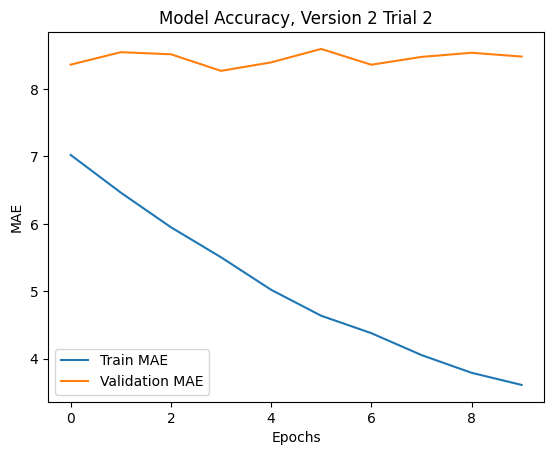

In [ ]:
# Trial 2 (RGB)
epochs = list(range(1, 11))
mae_2 = [7.020732879638672, 6.4622111320495605, 5.949060440063477, 5.503737926483154, 5.021727085113525, 4.636434555053711, 4.378624439239502, 4.054207801818848, 3.7909607887268066, 3.610996723175049]
val_mae_2 = [8.359553337097168, 8.544313430786133, 8.513622283935547, 8.267542839050293, 8.393195152282715, 8.592748641967773, 8.358521461486816, 8.47401237487793, 8.5360107421875, 8.479294776916504]
loss_2 = [84.27149963378906, 71.6761474609375, 59.801029205322266, 50.81813430786133, 41.832847595214844, 35.92060089111328, 31.544158935546875, 27.082508087158203, 23.75102996826172, 21.59292984008789]
val_loss_2 = [118.93006896972656, 122.75640869140625, 124.62127685546875, 118.75439453125, 125.09637451171875, 127.47290802001953, 126.1072998046875, 128.4408416748047, 130.30816650390625, 126.53807067871094]

plt.plot(mae_2, label='Train MAE')
plt.plot(val_mae_2, label='Validation MAE')
plt.title('Model Accuracy, Version 2 Trial 2')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()